<a href="https://colab.research.google.com/github/filetando/AvantiMachineLearning/blob/main/segmentacao_em_ambientes_naturais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instalar bibliotecas e baixar o dataset do kaggle

In [28]:
!pip install opendatasets
!pip install pandas
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.0 MB/s eta 0:00:00


Código novo até aqui

In [ ]:
import os
import pandas as pd
from PIL import Image
import opendatasets as od
import matplotlib.pyplot as plt

In [ ]:
od.download("https://www.kaggle.com/datasets/carlolepelaars/camvid")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lucasfileto
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid


100%|██████████| 575M/575M [00:11<00:00, 52.4MB/s]


# 2. Verificação da quantidade de imagens e máscaras por pasta

In [ ]:
dir_test = "/content/camvid/CamVid/test"
dir_test_labels = "/content/camvid/CamVid/test_labels"
dir_train = "/content/camvid/CamVid/train"
dir_train_labels = "/content/camvid/CamVid/train_labels"
dir_val = "/content/camvid/CamVid/val"
dir_val_labels = "/content/camvid/CamVid/val_labels"

dir_test_num = len(os.listdir(dir_test))
dir_test_labels_num = len(os.listdir(dir_test_labels))
dir_train_num = len(os.listdir(dir_train))
dir_train_labels_num = len(os.listdir(dir_train_labels))
dir_val_num = len(os.listdir(dir_val))
dir_val_labels_num = len(os.listdir(dir_val_labels))

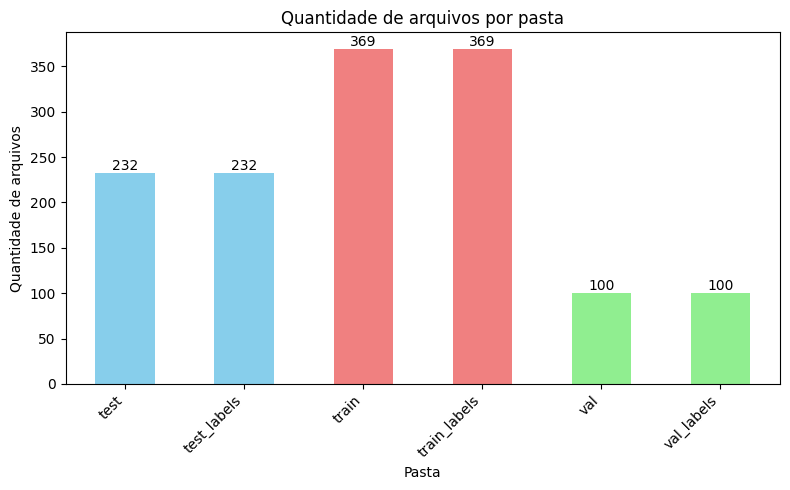

In [ ]:
# Criando DataFrame
data = {
    'Quantidade de arquivos': [dir_test_num, dir_test_labels_num, dir_train_num, dir_train_labels_num, dir_val_num, dir_val_labels_num]
}
index = ['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']
df = pd.DataFrame(data, index=index)

# Definindo cores por grupo
colors = ['skyblue', 'skyblue', 'lightcoral', 'lightcoral', 'lightgreen', 'lightgreen']

# Criando gráfico de barras
plt.figure(figsize=(8, 5))
ax = df['Quantidade de arquivos'].plot(kind='bar', color=colors, legend=False) # Apply colors to the Series
plt.title('Quantidade de arquivos por pasta')
plt.xlabel('Pasta')
plt.ylabel('Quantidade de arquivos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Adicionando valores nas barras
for container in ax.containers:
    ax.bar_label(container)

plt.show()

# 3. Verificando formato dos arquivos

In [ ]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

In [ ]:
def verificar_formato(dir):
  formatos = {}
  erros = []

  for arquivo in os.listdir(dir):
    caminho_completo = os.path.join(dir, arquivo)

    if os.path.isdir(caminho_completo):
      continue

    try:
      img = Image.open(caminho_completo)
      formato = img.format

      if formato in formatos:
        formatos[formato] += 1
      else:
        formatos[formato] = 1

    except Exception as e:
      erros.append(f'Erro ao abrir {arquivo}: {e}')

  return formatos,erros

def processar_diretorios_para_tabela(diretorios):
    todos_formatos = {}
    todos_erros = []

    for nome_diretorio, caminho_diretorio in diretorios.items():
        formatos, erros = verificar_formato(caminho_diretorio)
        todos_erros.extend(erros)

        for formato, quantidade in formatos.items():
            if nome_diretorio not in todos_formatos:
                todos_formatos[nome_diretorio] = {}
            todos_formatos[nome_diretorio][formato] = quantidade

    if todos_erros:
        print('Arquivos com erro:')
        for erro in todos_erros:
            print(erro)

    if todos_formatos:
        df_formatos = pd.DataFrame(todos_formatos).fillna(0).T
        df_formatos['Total'] = df_formatos.sum(axis=1)
        print("Formatos de Arquivo por Pasta")
        display(df_formatos)


diretorios = {
    'test': dir_test,
    'test_labels': dir_test_labels,
    'train': dir_train,
    'train_labels': dir_train_labels,
    'val': dir_val,
    'val_labels': dir_val_labels
}

processar_diretorios_para_tabela(diretorios)

Formatos de Arquivo por Pasta


,PNG,Total
test,232,232
test_labels,232,232
train,369,369
train_labels,369,369
val,100,100
val_labels,100,100


# 5. Explorando o arquivo `class_dict.csv`

In [ ]:
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"

try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    print(f"Conteúdo do arquivo: {caminho_class_dict}")
    display(df_class_dict)
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")

Conteúdo do arquivo: /content/camvid/CamVid/class_dict.csv


,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


# 6. Verificação de valores ausentes

In [ ]:
# ELIMINAR

# Verificar valores ausentes no DataFrame df_class_dict
valores_ausentes = df_class_dict.isnull().sum()

print("Valores ausentes no DataFrame df_class_dict:")
display(valores_ausentes)

Valores ausentes no DataFrame df_class_dict:


,0
name,0
r,0
g,0
b,0


# 7. Verificando inconsistência nas imagens

In [ ]:
def verificar_dimensoes_imagens_df(diretorio):
    dimensoes_contagem = {}
    erros_abrir = 0

    arquivos = os.listdir(diretorio)
    if not arquivos:
        return {'diretorio': diretorio}

    # Verificar as dimensões de todas as imagens
    for arquivo in arquivos:
        caminho_completo = os.path.join(diretorio, arquivo)
        if os.path.isdir(caminho_completo):
            continue
        try:
            with Image.open(caminho_completo) as img:
                dimensao = img.size
                if dimensao in dimensoes_contagem:
                    dimensoes_contagem[dimensao] += 1
                else:
                    dimensoes_contagem[dimensao] = 1
        except Exception as e:
             erros_abrir += 1

    return {'diretorio': diretorio, **dimensoes_contagem}


# Coletar informações de dimensões de todos os diretórios de imagens e máscaras
print("Verificando dimensões das imagens e máscaras:")

resultados_dimensoes = []
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_test_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_train_labels))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val))
resultados_dimensoes.append(verificar_dimensoes_imagens_df(dir_val_labels))

# Criar DataFrame a partir dos resultados coletados
df_dimensoes = pd.DataFrame(resultados_dimensoes)

# Extrair apenas o último nome do diretório
df_dimensoes['Nome_do_diretorio'] = df_dimensoes['diretorio'].apply(lambda x: os.path.basename(x))

# Remover a coluna original 'diretorio'
df_dimensoes = df_dimensoes.drop('diretorio', axis=1)

# Reordenar as colunas para colocar 'Nome_do_diretorio' como a primeira coluna
cols = ['Nome_do_diretorio'] + [col for col in df_dimensoes.columns if col != 'Nome_do_diretorio']
df_dimensoes = df_dimensoes[cols]

print("\nResumo das dimensões das imagens por diretório:")
display(df_dimensoes)

Verificando dimensões das imagens e máscaras:

Resumo das dimensões das imagens por diretório:


,Nome_do_diretorio,"(960, 720)"
0,test,232
1,test_labels,232
2,train,369
3,train_labels,369
4,val,100
5,val_labels,100


##Verificar dados corrompidos

In [ ]:
def find_corrupted_images(directory):

    corrupted_images = []
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            # Attempt to open and close the image
            with Image.open(filepath) as img:
                img.verify() # Verify that the file is an image
        except Exception as e:
            corrupted_images.append({'arquivo': filename, 'diretorio': directory, 'erro': str(e)})
    return corrupted_images

# Directories to check
image_directories = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_corrupted_images = []
print("Verificando imagens corrompidas:")
for directory in image_directories:
    print(f"Verificando diretório: {directory}")
    corrupted_images_in_dir = find_corrupted_images(directory)
    all_corrupted_images.extend(corrupted_images_in_dir)

if all_corrupted_images:
    print("\nImagens corrompidas encontradas:")
    df_corrupted = pd.DataFrame(all_corrupted_images)
    display(df_corrupted)
else:
    print("\nNão foram encontradas imagens corrompidas em nenhum dos diretórios.")

Verificando imagens corrompidas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens corrompidas em nenhum dos diretórios.


##Distribuição de classes

In [ ]:
import numpy as np

def check_class_presence(image_path, class_mapping):
    """Checks which classes are present in a mask image."""
    present_classes = set()
    try:
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)

        for color, name in class_mapping.items():
            # Check if the color is present in the image array
            if np.any(np.all(img_array == color, axis=-1)):
                present_classes.add(name)

    except Exception as e:
        print(f"Erro ao processar a imagem {image_path}: {e}")

    return present_classes

# Load the class dictionary
caminho_class_dict = "/content/camvid/CamVid/class_dict.csv"
try:
    df_class_dict = pd.read_csv(caminho_class_dict)
    # Create a mapping from color tuple to class name
    class_mapping = {tuple(row[['r', 'g', 'b']].values): row['name'] for index, row in df_class_dict.iterrows()}
except FileNotFoundError:
    print(f"Erro: O arquivo {caminho_class_dict} não foi encontrado.")
    class_mapping = {}
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo {caminho_class_dict}: {e}")
    class_mapping = {}


# Directory containing the label images
dir_test_labels = "/content/camvid/CamVid/test_labels"

# Initialize a dictionary to store the count of images where each class appears
class_image_counts = {}

if class_mapping:
    # Initialize counts for all classes to 0
    for name in class_mapping.values():
        class_image_counts[name] = 0

    # Iterate through each label image in the directory
    for filename in os.listdir(dir_test_labels):
        if filename.endswith(".png"): # Assuming label images are PNGs
            image_path = os.path.join(dir_test_labels, filename)
            present_classes = check_class_presence(image_path, class_mapping)

            # Increment the count for each present class
            for class_name in present_classes:
                class_image_counts[class_name] += 1

    # Create a DataFrame from the image counts and rank them
    if class_image_counts:
        df_ranking_images = pd.DataFrame(list(class_image_counts.items()), columns=['Classe', 'Número de Imagens'])
        df_ranking_images = df_ranking_images.sort_values(by='Número de Imagens', ascending=False).reset_index(drop=True)
        df_ranking_images.index = df_ranking_images.index + 1 # Start ranking from 1

        print("\nRanking de Classes por Número de Imagens nas Máscaras de Teste:")
        display(df_ranking_images)
    else:
        print("\nNenhuma classe encontrada nas máscaras de teste.")
else:
    print("\nMapeamento de classes não disponível. Não é possível gerar o ranking.")


Ranking de Classes por Número de Imagens nas Máscaras de Teste:


,Classe,Número de Imagens
1,Column_Pole,232
2,Void,232
3,Sky,232
4,Road,232
5,LaneMkgsDriv,231
6,Building,226
7,Sidewalk,224
8,Car,220
9,Pedestrian,218
10,Tree,216


##Investigação das duplicatas

In [31]:
import hashlib
import os
import pandas as pd

def hash_file(filepath):
    """Calculates the MD5 hash of a file."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        while chunk := f.read(4096):
            hasher.update(chunk)
    return hasher.hexdigest()

def find_exact_duplicate_images(directory):
    """Finds exact duplicate images in a directory using cryptographic hashing."""
    hashes = {}
    duplicates = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            file_hash = hash_file(filepath)
            if file_hash in hashes:
                duplicates.append((hashes[file_hash], filepath))
            else:
                hashes[file_hash] = filepath
        except Exception as e:
            print(f"Erro ao processar o arquivo {filepath}: {e}")

    return duplicates

# Directories to check for exact duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
    dir_test_labels,
    dir_train_labels,
    dir_val_labels
]

all_exact_duplicates = []
print("Verificando imagens duplicadas exatas:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    exact_duplicates_in_dir = find_exact_duplicate_images(directory)
    all_exact_duplicates.extend(exact_duplicates_in_dir)

if all_exact_duplicates:
    print("\nImagens duplicadas exatas encontradas:")
    df_exact_duplicates = pd.DataFrame(all_exact_duplicates, columns=['Imagem 1', 'Imagem 2'])
    display(df_exact_duplicates)
else:
    print("\nNão foram encontradas imagens duplicadas exatas em nenhum dos diretórios.")

Verificando imagens duplicadas exatas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val
Verificando diretório: /content/camvid/CamVid/test_labels
Verificando diretório: /content/camvid/CamVid/train_labels
Verificando diretório: /content/camvid/CamVid/val_labels

Não foram encontradas imagens duplicadas exatas em nenhum dos diretórios.


##Investigação de Imagens Similares

In [29]:
import imagehash
from PIL import Image
import os
import pandas as pd

def find_duplicate_images(directory, threshold=5):
    """Finds potential duplicate images in a directory using perceptual hashing.

    Args:
        directory (str): The path to the directory containing images.
        threshold (int): The maximum Hamming distance between two hashes to consider images as potential duplicates.

    Returns:
        list: A list of tuples, where each tuple contains the paths of potential duplicate images.
    """
    hashes = {}
    duplicates = []

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isdir(filepath):
            continue  # Skip directories
        try:
            with Image.open(filepath) as img:
                img_hash = imagehash.phash(img)
                if img_hash in hashes:
                    # Check Hamming distance
                    if img_hash - hashes[img_hash]['hash'] <= threshold:
                         duplicates.append((hashes[img_hash]['filepath'], filepath))
                    else:
                        hashes[img_hash] = {'filepath': filepath, 'hash': img_hash} # Update with the new hash
                else:
                    hashes[img_hash] = {'filepath': filepath, 'hash': img_hash}
        except Exception as e:
            print(f"Erro ao processar a imagem {filepath}: {e}")

    return duplicates

# Directories to check for duplicates
image_directories_to_check = [
    dir_test,
    dir_train,
    dir_val,
]

all_duplicates = []
print("Verificando imagens similares:")
for directory in image_directories_to_check:
    print(f"Verificando diretório: {directory}")
    duplicates_in_dir = find_duplicate_images(directory)
    all_duplicates.extend(duplicates_in_dir)

if all_duplicates:
    print("\nImagens muito similares foram encontradas:")
    df_duplicates = pd.DataFrame(all_duplicates, columns=['Imagem 1', 'Imagem 2'])
    display(df_duplicates)
else:
    print("\nNão foram encontradas imagens duplicadas em nenhum dos diretórios.")

Verificando imagens duplicadas:
Verificando diretório: /content/camvid/CamVid/test
Verificando diretório: /content/camvid/CamVid/train
Verificando diretório: /content/camvid/CamVid/val

Imagens duplicadas encontradas:


,Imagem 1,Imagem 2
0,/content/camvid/CamVid/test/Seq05VD_f02610.png,/content/camvid/CamVid/test/Seq05VD_f02070.png
1,/content/camvid/CamVid/test/Seq05VD_f02040.png,/content/camvid/CamVid/test/Seq05VD_f02640.png
2,/content/camvid/CamVid/test/0016E5_08029.png,/content/camvid/CamVid/test/0016E5_08027.png
3,/content/camvid/CamVid/test/0016E5_08067.png,/content/camvid/CamVid/test/0016E5_08065.png
4,/content/camvid/CamVid/test/Seq05VD_f02040.png,/content/camvid/CamVid/test/Seq05VD_f02580.png
5,/content/camvid/CamVid/test/Seq05VD_f02610.png,/content/camvid/CamVid/test/Seq05VD_f02010.png
6,/content/camvid/CamVid/test/0016E5_04500.png,/content/camvid/CamVid/test/0016E5_04440.png
7,/content/camvid/CamVid/test/0001TP_009360.png,/content/camvid/CamVid/test/0001TP_009330.png
8,/content/camvid/CamVid/test/Seq05VD_f02610.png,/content/camvid/CamVid/test/Seq05VD_f01980.png
9,/content/camvid/CamVid/test/0016E5_08127.png,/content/camvid/CamVid/test/0016E5_08125.png
